# Custom model and Transform

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/custom_transform_and_model.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of custom model and Transform that can be added to the ETNA framework.

**Table of Contents**

* [What is Transform and how it works](#chapter1)  
* [Custom Transform](#chapter2)
* [Custom Model](#chapter3)

In [1]:
import pandas as pd
from etna.datasets.tsdataset import TSDataset
from etna.transforms import DateFlagsTransform, LinearTrendTransform

import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


## 1. What is Transform and how it works <a class="anchor" id="chapter1"></a>

Our library works with the spacial data structure TSDataset. So, before starting, we need to convert the classical DataFrame to TSDataset.

In [2]:
df = pd.read_csv("data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


Let's look at the original view of data

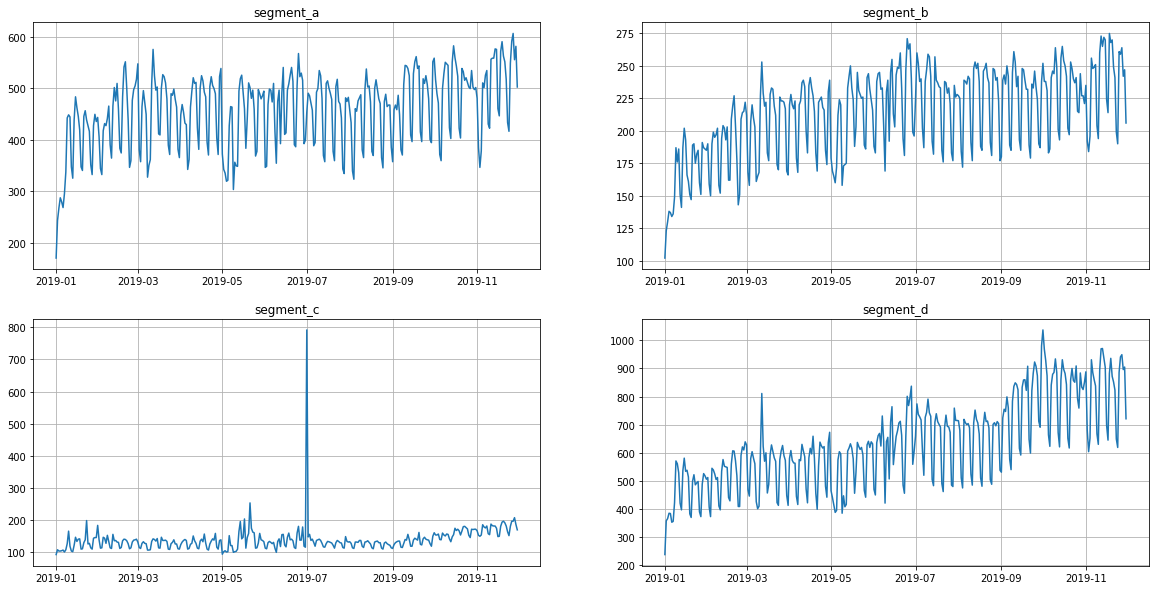

In [3]:
ts.plot()

Transform is the manipulation of data to extract new features or update created ones. 

In ETNA, Transforms can change column values ​​or add new ones. 

For example:

*   DateFlagsTransform - 
adds columns with information about the date (day number, is the day a weekend, etc.) .
*   LinearTrendTransform - subtracts a linear trend from the series (changes it).



In [4]:
dates = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
detrend = LinearTrendTransform(in_column="target")

ts.fit_transform([dates, detrend])

ts.head(3)

segment                      segment_a                                  \
feature    dateflag_day_number_in_week dateflag_is_weekend      target   
timestamp                                                                
2019-01-01                           1               False -236.276825   
2019-01-02                           2               False -163.575877   
2019-01-03                           3               False -139.874928   

segment                      segment_b                                 \
feature    dateflag_day_number_in_week dateflag_is_weekend     target   
timestamp                                                               
2019-01-01                           1               False -79.162964   
2019-01-02                           2               False -58.358457   
2019-01-03                           3               False -51.553950   

segment                      segment_c                                 \
feature    dateflag_day_number_in_week dateflag_is_weekend     target   
timestamp                                                               
2019-01-01                           1               False -26.743498   
2019-01-02                           2               False -11.861383   
2019-01-03                           3               False -15.979267   

segment                      segment_d                                  
feature    dateflag_day_number_in_week dateflag_is_weekend      target  
timestamp                                                               
2019-01-01                           1               False -194.070140  
2019-01-02                           2               False  -75.292679  
2019-01-03                           3               False  -68.515217

In addition to the appearance of a new column, the values ​​in the target column have changed. This can be seen from the graphs.

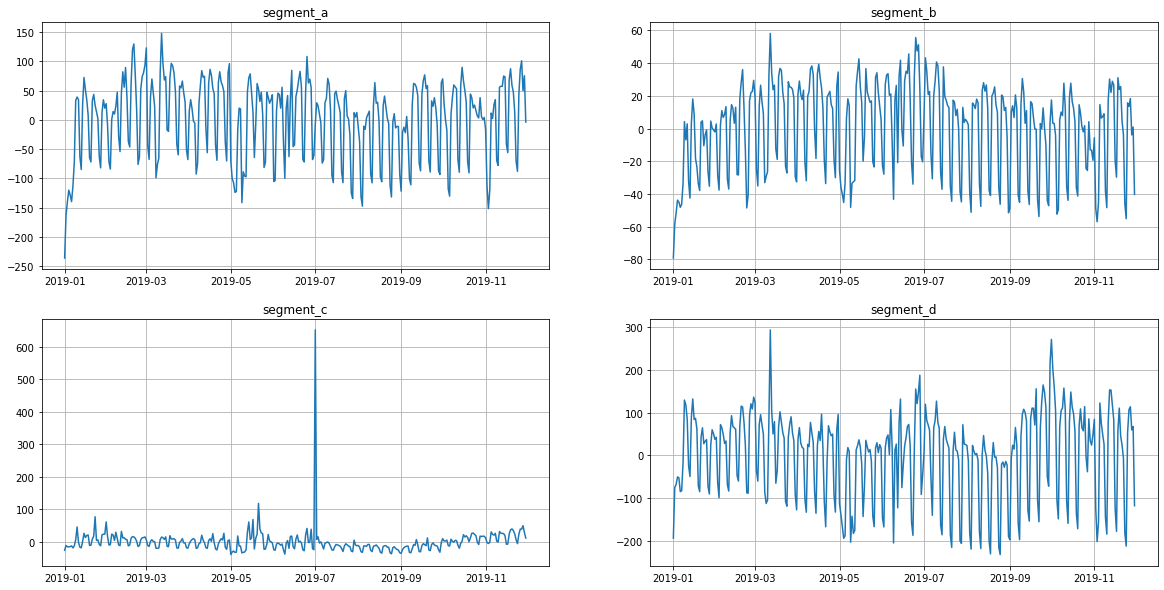

In [5]:
ts.plot()

In [6]:
ts.inverse_transform()
ts.head(3)

segment                      segment_a                             \
feature    dateflag_day_number_in_week dateflag_is_weekend target   
timestamp                                                           
2019-01-01                           1               False  170.0   
2019-01-02                           2               False  243.0   
2019-01-03                           3               False  267.0   

segment                      segment_b                             \
feature    dateflag_day_number_in_week dateflag_is_weekend target   
timestamp                                                           
2019-01-01                           1               False  102.0   
2019-01-02                           2               False  123.0   
2019-01-03                           3               False  130.0   

segment                      segment_c                             \
feature    dateflag_day_number_in_week dateflag_is_weekend target   
timestamp                                                           
2019-01-01                           1               False   92.0   
2019-01-02                           2               False  107.0   
2019-01-03                           3               False  103.0   

segment                      segment_d                             
feature    dateflag_day_number_in_week dateflag_is_weekend target  
timestamp                                                          
2019-01-01                           1               False  238.0  
2019-01-02                           2               False  358.0  
2019-01-03                           3               False  366.0

Now the data is back in its original form

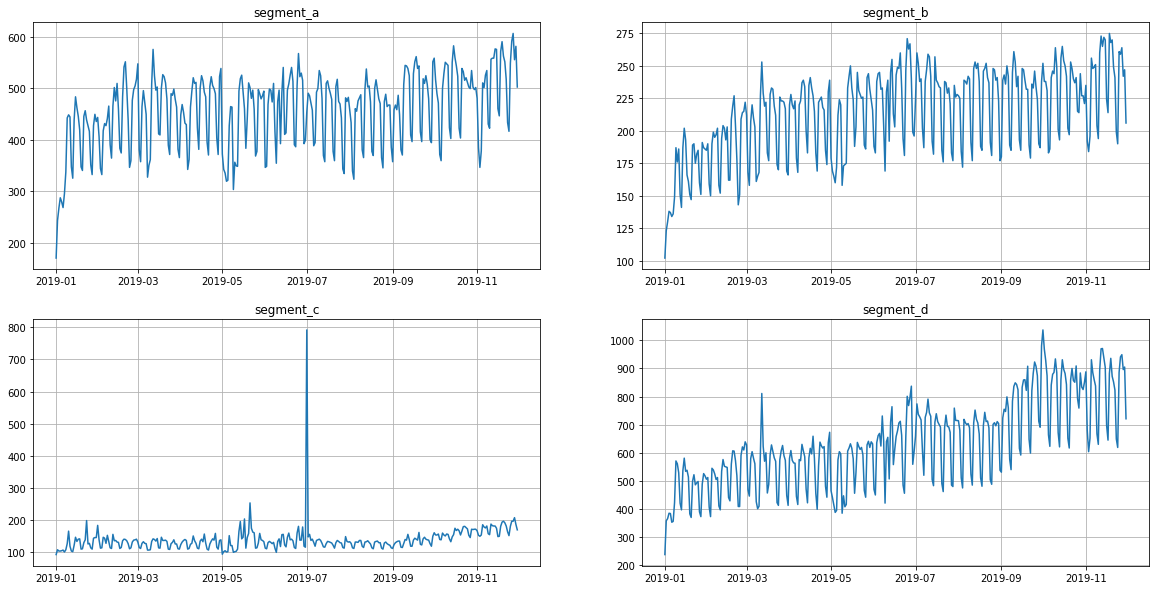

In [7]:
ts.plot()

## 2. Custom Transform <a class="anchor" id="chapter2"></a>

Let's define custom Transform.

Consider a Transform that sets bounds at the top and bottom - FloorCeilTransform

ETNA use PerSegmentWrapper, so it is enough to describe the transformation for one segment and then apply it.


Any Transform inherits from the base class.

In [8]:
from etna.transforms.base import PerSegmentWrapper
from etna.transforms.base import Transform

In [9]:
# Class for processing one segment.
class _OneSegmentFloorCeilTransform(Transform):

    # Constructor with the name of the column to which the transformation will be applied.
    def __init__(self, in_column: str, floor: float, ceil: float):
        """
        Create instance of _OneSegmentLinearTrendBaseTransform.

        Parameters
        ----------
        in_column:
            name of processed column
        floor:
            lower bound
        ceil:
            upper bound
        """
        self.in_column = in_column
        self.floor = floor
        self.ceil = ceil

    # Provide the necessary training. For example calculates the coefficients of a linear trend.
    # In this case, we calculate the indices that need to be changed
    # and remember the old values for inverse transform.
    def fit(self, df: pd.DataFrame) -> "_OneSegmentFloorCeilTransform":
        """
        Calculate the indices that need to be changed.

        Returns
        -------
        self
        """
        target_column = df[self.in_column]

        self.floor_indices = target_column < self.floor
        self.floor_values = target_column[self.floor_indices]

        self.ceil_indices = target_column > self.ceil
        self.ceil_values = target_column[self.ceil_indices]

        return self

    # Apply changes.
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Drive the value to the interval [floor, ceil].

        Parameters
        ----------
        df:
            DataFrame to transform

        Returns
        -------
        transformed series
        """
        result_df = df.copy()
        result_df[self.in_column].iloc[self.floor_indices] = self.floor
        result_df[self.in_column].iloc[self.ceil_indices] = self.ceil

        return result_df

    # Do it all in one action. Base class requirement.
    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.fit(df).transform(df)

    # Returns back changed values.
    def inverse_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Inverse transformation for transform. Return back changed values.

        Parameters
        ----------
        df:
            data to transform

        Returns
        -------
        pd.DataFrame
            reconstructed data
        """
        result = df.copy()
        result[self.in_column][self.floor_indices] = self.floor_values
        result[self.in_column][self.ceil_indices] = self.ceil_values

        return result

Now we can define class, which will work with the entire dataset, applying a transform(*_OneSegmentFloorCeilTransform*) to each segment. 

This functionality is provided by *PerSegmentWrapper*.

In [10]:
class FloorCeilTransform(PerSegmentWrapper):
    """Transform that truncate values to an interval [ceil, floor]"""

    def __init__(self, in_column: str, floor: float, ceil: float):
        """Create instance of FloorCeilTransform.
        Parameters
        ----------
        in_column:
            name of processed column
        floor:
            lower bound
        ceil:
            upper bound
        """
        self.in_column = in_column
        self.floor = floor
        self.ceil = ceil
        super().__init__(
            transform=_OneSegmentFloorCeilTransform(in_column=self.in_column, floor=self.floor, ceil=self.ceil)
        )

Lets take a closer look.

This is what the original data looks like.

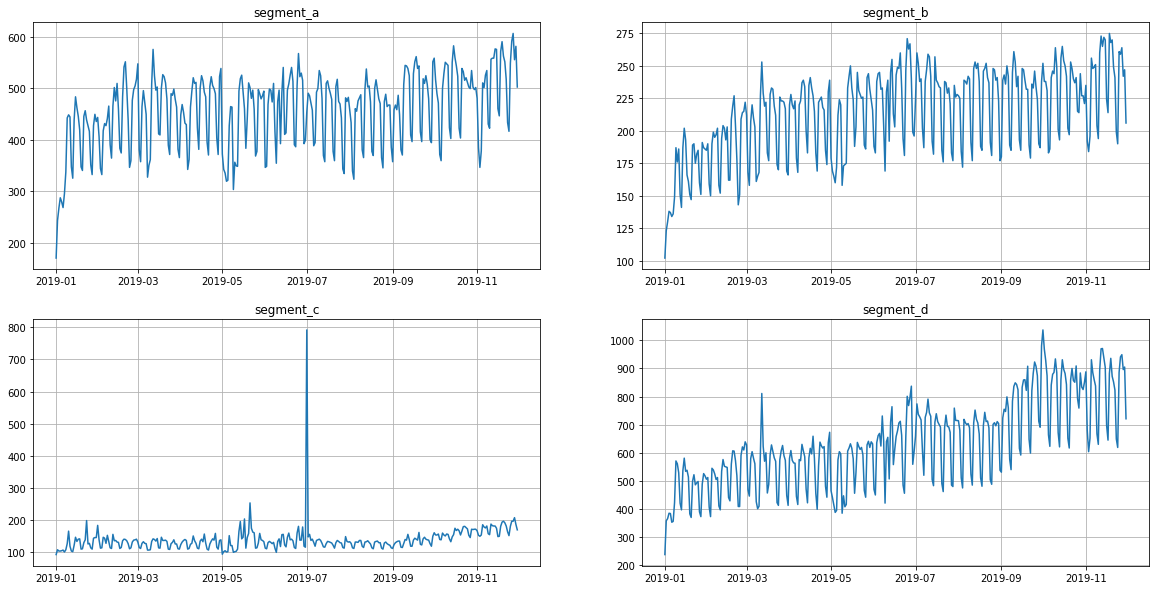

In [11]:
ts.plot()

In [12]:
bounds = FloorCeilTransform(in_column="target", floor=150, ceil=600)

ts.fit_transform([bounds])

The values ​​are now limited. Let's see how it looks

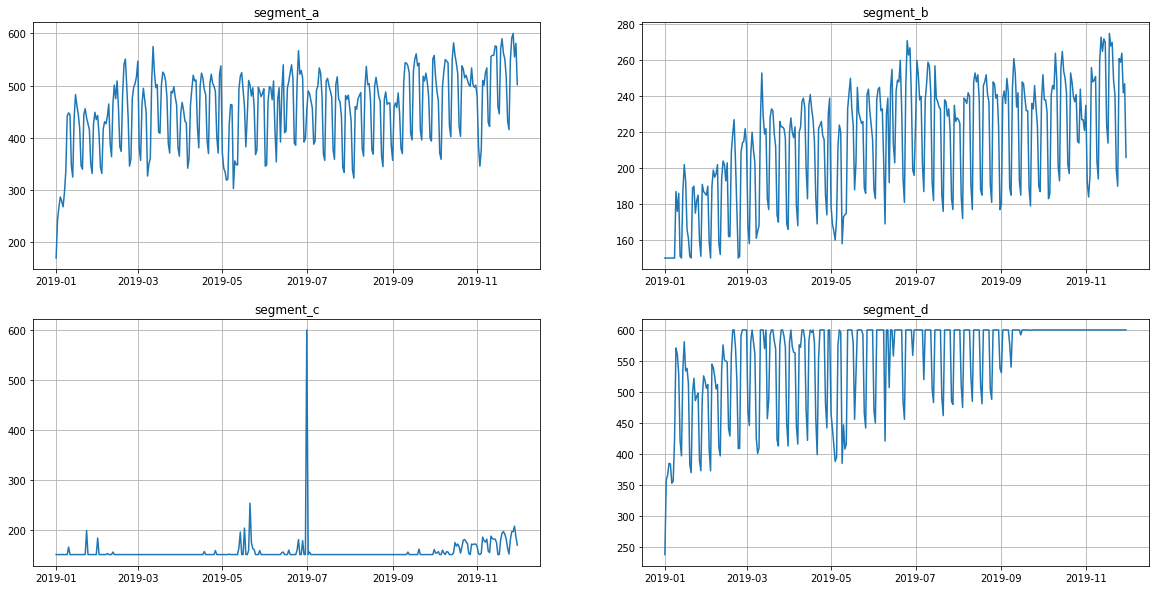

In [13]:
ts.plot()

Returning to the original values

In [14]:
ts.inverse_transform()

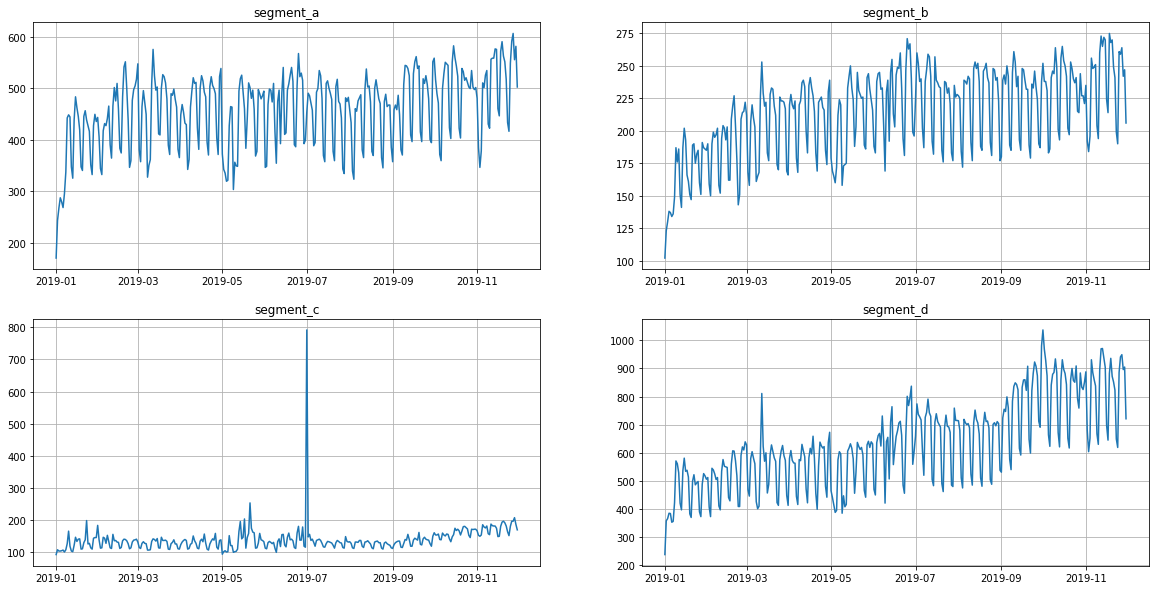

In [15]:
ts.plot()

Everything seems to be working correctly. Remember to write the necessary [tests](https://github.com/tinkoff-ai/etna/tree/master/tests) before adding a new transform to the library.

## 3. Custom Model <a class="anchor" id="chapter3"></a>

If you could not find a suitable model among the [ready-made ones](https://github.com/tinkoff-ai/etna/tree/master/etna/models), then you can create your own.

In this example we will try to add model based on `lightgbm` package.

In [16]:
!pip install lightgbm -q

### Creating a new model from scratch

First, let's look at creating a new model from scratch. First of all, we should choose our base class. There are:
* `NonPredictionIntervalContextIgnorantAbstractModel`: model can't generate prediction intervals and doesn't require context to make predictions,
* `NonPredictionIntervalContextRequiredAbstractModel`: model can't generate prediction intervals and requires context to make predictions,
* `PredictionIntervalContextIgnorantAbstractModel`: model can generate prediction intervals and doesn't require context to make predictions,
* `PredictionIntervalContextRequiredAbstractModel`: model can generate prediction intervals and requires context to make predictions.

These classes have different signatures for `forecast` and `predict` methods depending on their name. 
* All signatures accept `ts: TSDataset` parameter for making prediction. 
* If a model can generate prediction intervals it also accepts `prediction_interval: bool` and `quantiles: Sequence[float]` parameters.
* If a model requires context it also accepts `prediction_size: int` parameter, that is required to distinguish history context from points we want to make prediction on.

Let's make some clarifications about the context. It is a part of a dataset before prediction points that is necessary for making forecasts. It is necessary for models that in its core use previous points to make predictions into the future. The example is `etna.models.NaiveMode(lag=1)` that uses last point to predict the next.

Ok, what about model based on `lightgbm`? This model doesn't require context and we will make implementation that doesn't generate prediction intervals.

In [17]:
from lightgbm import LGBMRegressor
from etna.models.base import NonPredictionIntervalContextIgnorantAbstractModel
from etna.pipeline import Pipeline

Let's look at implementation.

In [18]:
class LGBMModel(NonPredictionIntervalContextIgnorantAbstractModel):
    def __init__(
        self,
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs,
    ):
        self.boosting_type = boosting_type
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.kwargs = kwargs
        self.model = LGBMRegressor(
            boosting_type=self.boosting_type,
            num_leaves=self.num_leaves,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            n_estimators=self.n_estimators,
            **self.kwargs,
        )

    def fit(self, ts: TSDataset) -> "LGBMModel":
        """Fit model.

        Parameters
        ----------
        ts:
            Dataset with features

        Returns
        -------
        :
            Model after fit
        """
        df = ts.to_pandas(flatten=True)
        df = df.dropna()
        features = df.drop(columns=["timestamp", "segment", "target"])
        self._categorical = features.select_dtypes(include=["category"]).columns.to_list()
        target = df["target"]
        self.model.fit(X=features, y=target, categorical_feature=self._categorical)

    def forecast(self, ts: TSDataset) -> TSDataset:
        """Make predictions.

        Parameters
        ----------
        ts:
            Dataset with features

        Returns
        -------
        :
            Dataset with predictions
        """
        horizon = len(ts.df)
        df = ts.to_pandas(flatten=True)
        features = df.drop(columns=["timestamp", "segment", "target"])
        y_flat = self.model.predict(features)
        y = y_flat.reshape(-1, horizon).T
        ts.loc[:, pd.IndexSlice[:, "target"]] = y
        ts.inverse_transform()
        return ts

    def predict(self, ts: TSDataset) -> TSDataset:
        """Make predictions.

        Parameters
        ----------
        ts:
            Dataset with features

        Returns
        -------
        :
            Dataset with predictions
        """
        return self.forecast(ts=ts)

    def get_model(self) -> LGBMRegressor:
        """Get internal lightgbm model.

        Returns
        -------
        :
            lightgbm model.
        """
        return self.model

Let's test it.

In [19]:
HORIZON = 31

train_ts, test_ts = ts.train_test_split(
    train_start="2019-01-01",
    train_end="2019-10-30",
    test_start="2019-10-31",
    test_end="2019-11-30",
)

In [20]:
from etna.transforms import LagTransform
from etna.transforms import LogTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import DateFlagsTransform
from etna.transforms import LinearTrendTransform

log = LogTransform(in_column="target", out_column="log")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(31, 96, 1)), out_column="lag")
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6],
    out_column="date_feature",
)

transforms = [trend, lags, d_flags, seg]

In [21]:
model = LGBMModel(random_state=42)
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
pipeline.fit(train_ts)
forecast_ts = pipeline.forecast()

Let's look at the results.

In [22]:
from etna.analysis import plot_forecast

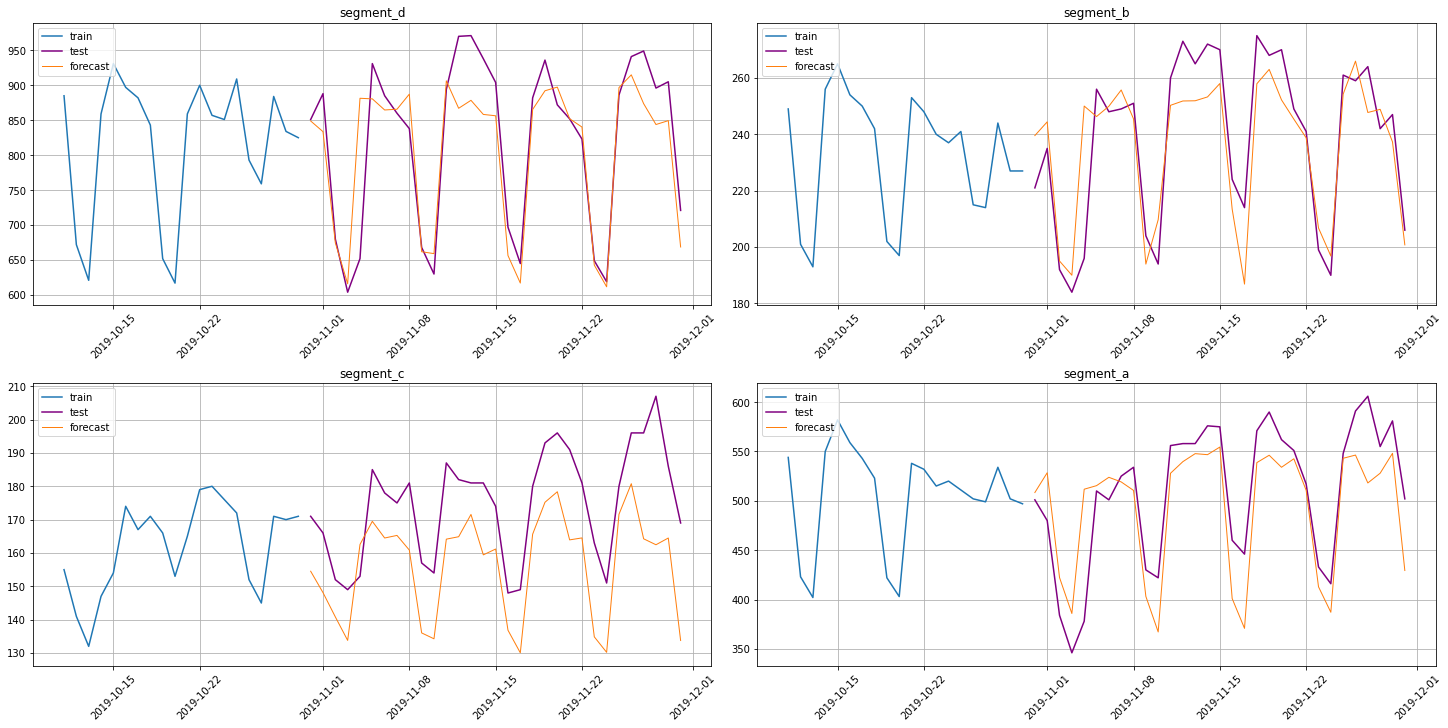

In [23]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

As we can see, predictions make sense.

### Creating a new model using sklearn interface

Now let's create our model by leveraging already existing etna classes: 
* `etna.models.SklearnPerSegmentModel`: accepts sklearn-like model and creates etna-model that fits one model per each segment.
* `etna.models.SklearnMultiSegmentModel`: accepts sklearn-like model and creates etna-model that fits one model on entire dataset & mdash; it is that we implemented in a section above.

In [24]:
from etna.models import SklearnPerSegmentModel
from etna.models import SklearnMultiSegmentModel

First, let's implement etna-model that fits separate model per each segment.

In [25]:
class LGBMPerSegmentModel(SklearnPerSegmentModel):
    def __init__(
        self,
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs,
    ):
        self.boosting_type = boosting_type
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.kwargs = kwargs
        model = LGBMRegressor(
            boosting_type=self.boosting_type,
            num_leaves=self.num_leaves,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            n_estimators=self.n_estimators,
            **self.kwargs,
        )
        super().__init__(regressor=model)


class LGBMMultiSegmentModel(SklearnMultiSegmentModel):
    def __init__(
        self,
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs,
    ):
        self.boosting_type = boosting_type
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.kwargs = kwargs
        model = LGBMRegressor(
            boosting_type=self.boosting_type,
            num_leaves=self.num_leaves,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            n_estimators=self.n_estimators,
            **self.kwargs,
        )
        super().__init__(regressor=model)

Let's try to recreate results of `LGBMModel` using `LGBMMultiSegmentModel`.

In [26]:
train_ts, test_ts = ts.train_test_split(
    train_start="2019-01-01",
    train_end="2019-10-30",
    test_start="2019-10-31",
    test_end="2019-11-30",
)

In [27]:
log = LogTransform(in_column="target", out_column="log")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(31, 96, 1)), out_column="lag")
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6],
    out_column="date_feature",
)

transforms = [trend, lags, d_flags, seg]

In [28]:
model = LGBMMultiSegmentModel(random_state=42)
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
pipeline.fit(train_ts)
forecast_ts_mult_segment = pipeline.forecast()

Let's look at the results.

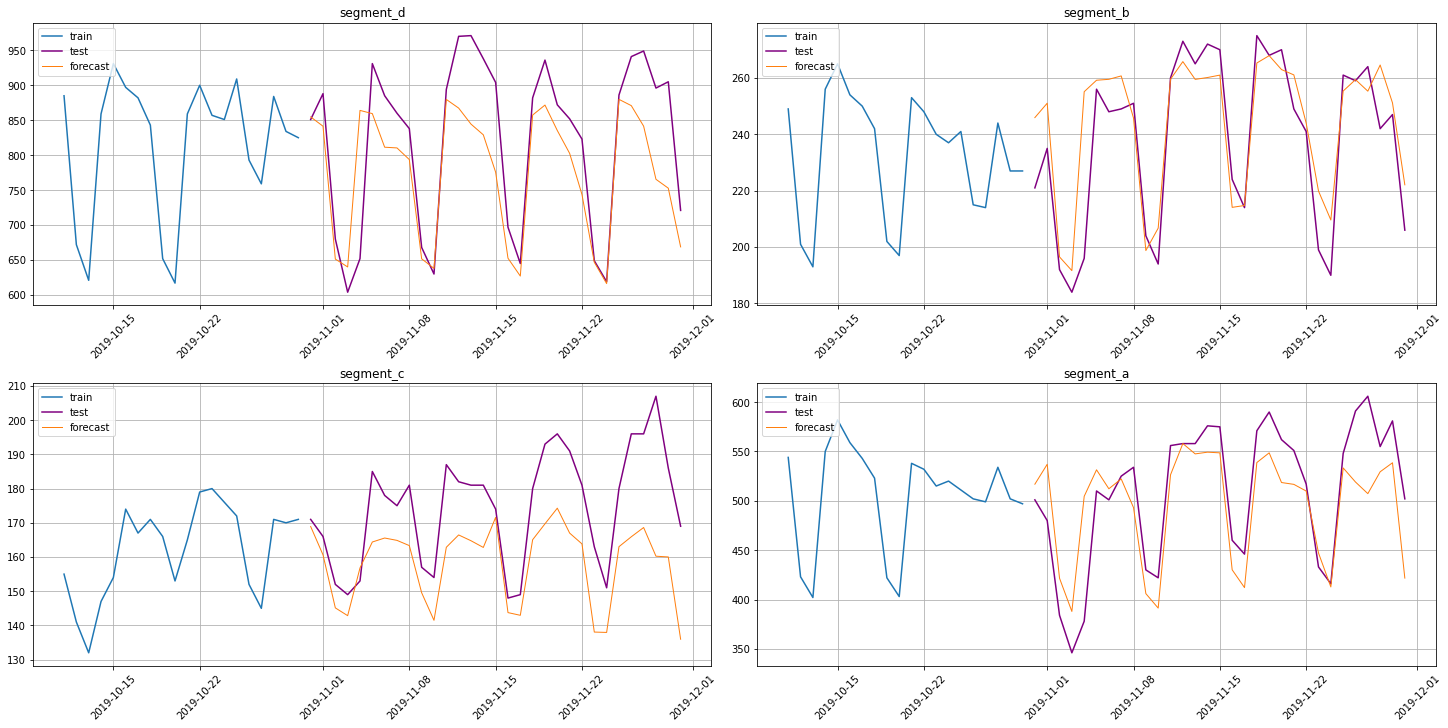

In [29]:
plot_forecast(forecast_ts_mult_segment, test_ts, train_ts, n_train_samples=20)

As we can see, the results are a little bit different. Let's check this manually by looking at the values.

In [30]:
forecast_df = forecast_ts.to_pandas(flatten=True)
forecast_df_multi_segent = forecast_ts_mult_segment.to_pandas(flatten=True)

In [31]:
forecast_df[["timestamp", "segment", "target"]].head()

,timestamp,segment,target
0,2019-10-31,segment_a,508.425382
1,2019-11-01,segment_a,528.454027
2,2019-11-02,segment_a,422.233377
3,2019-11-03,segment_a,385.819957
4,2019-11-04,segment_a,511.778336


In [32]:
forecast_df_multi_segent[["timestamp", "segment", "target"]].head()

,timestamp,segment,target
0,2019-10-31,segment_a,516.873254
1,2019-11-01,segment_a,537.026748
2,2019-11-02,segment_a,421.547966
3,2019-11-03,segment_a,387.897199
4,2019-11-04,segment_a,504.565340


Why do we see this difference? In `LGBMModel` we have a special handling of categorical features, but in `LGBMMultiSegmentModel` we doesn't have it, because `etna.models.SklearnMultiSegmentModel` doesn't implement this logic with categorical features.

As you can see, `etna.models.SklearnPerSegmentModel` and `etna.models.SklearnMultiSegmentModel` have some limitations, but they should cover a lot of cases.

This raises a question: what if I want to implement per-segment logic manually with handling categorical features like in `LGBMModel`? A good reference for such a task will be the implementations of `etna.models.CatBoostPerSegmentModel` and `etna.models.CatBoostMultiSegmentModel`. There we use special mixins for per-segment/multi-segment logic.

If you want to add you model to the library don't forget to write the necessary tests and documentation. Good luck!